# [T-Academy X KaKr] 성인 인구조사 소득 예측 대회

## 목적
 - 1994년 미국 성인을 대상으로 한 조사를 통해 연소득이 $50,000 이 넘는지 안 넘는지 구분하기

# Setting

In [ ]:
# t

In [2]:
import pandas as pd
import pandas_profiling
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
pd.options.display.max_rows=150
%matplotlib inline

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))
        
# import os
# os.listdir('../input/')

/kaggle/input/kakr-4th-competition/sample_submission.csv
/kaggle/input/kakr-4th-competition/test.csv
/kaggle/input/kakr-4th-competition/train.csv


In [3]:
path = '/kaggle/input/kakr-4th-competition/'

df = pd.read_csv(path + 'train.csv')
df_t = pd.read_csv(path + 'test.csv')
submission = pd.read_csv(path + 'sample_submission.csv')

print(df.shape)
print(df_t.shape)

(26049, 16)
(6512, 15)


# Data Processing (step.01)

In [4]:
# education 컬럼은 education_num과 1대1 매칭 >> education 컬럼 제외
# df['education'].value_counts().values - df['education_num'].value_counts().values
df = df.drop('education', axis = 1)

# income column >> 50K 기준으로 대소 비교 변수 파생 (True/False)
df['is_income_over_50K'] = df['income']=='>50K'

print(df.shape);  df.head(2)

(26049, 16)


,id,age,workclass,fnlwgt,education_num,marital_status,occupation,relationship,race,sex,capital_gain,capital_loss,hours_per_week,native_country,income,is_income_over_50K
0,0,40,Private,168538,9,Married-civ-spouse,Sales,Husband,White,Male,0,0,60,United-States,>50K,True
1,1,17,Private,101626,5,Never-married,Machine-op-inspct,Own-child,White,Male,0,0,20,United-States,<=50K,False


In [5]:
# # fnlwgt 컬럼은 사후 층화 가중치로서, 한 표본이 몇 개를 대표하는지 의미.
# # 'https://m.blog.naver.com/stat833/221747335785'
# df_fnlwgt = df.head(5)
# df_fnlwgt.drop(df_fnlwgt.index[0], inplace = True)
# df_fnlwgt

###  one-hot 인코딩

In [6]:
## train data

from sklearn.ensemble import RandomForestRegressor
from sklearn.preprocessing import LabelEncoder

dtypes = df.dtypes
encoders = {}
for column in df.columns:
    if str(dtypes[column]) == 'object':
        encoder = LabelEncoder()
        encoder.fit(df[column])
        encoders[column] = encoder
df_num = df.copy()

for column in encoders.keys():
    encoder = encoders[column]
    df_num[column] = encoder.transform(df[column])
    
print(df_num.shape)
df_num.tail(3)

(26049, 16)


,id,age,workclass,fnlwgt,education_num,marital_status,occupation,relationship,race,sex,capital_gain,capital_loss,hours_per_week,native_country,income,is_income_over_50K
26046,26046,78,0,165694,14,6,0,1,4,0,0,0,15,38,0,False
26047,26047,26,6,151626,9,4,10,3,2,0,0,0,40,38,0,False
26048,26048,20,0,99891,10,4,0,3,4,0,0,0,30,38,0,False


In [7]:
## test data

dtypes = df_t.dtypes
encoders = {}
for column in df_t.columns:
    if str(dtypes[column]) == 'object':
        encoder = LabelEncoder()
        encoder.fit(df_t[column])
        encoders[column] = encoder
df_num_t = df_t.copy()

for column in encoders.keys():
    encoder = encoders[column]
    df_num_t[column] = encoder.transform(df_t[column])
    
print(df_num_t.shape)
df_num_t.tail(3)

(6512, 15)


,id,age,workclass,fnlwgt,education,education_num,marital_status,occupation,relationship,race,sex,capital_gain,capital_loss,hours_per_week,native_country
6509,6509,39,4,409189,4,3,2,8,0,4,1,0,0,40,26
6510,6510,35,4,180342,11,9,2,3,0,4,1,0,0,40,39
6511,6511,28,4,156819,11,9,0,6,4,4,0,0,0,36,39


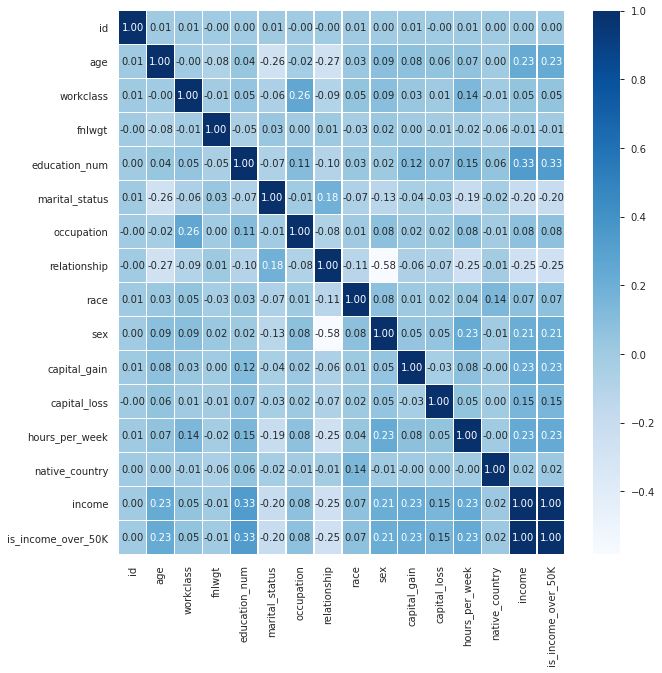

In [8]:
# 상관관계 heatmap

plt.figure(figsize=(10,10))
sns.heatmap(data = df_num.corr(), annot=True, 
fmt = '.2f', linewidths=.5, cmap='Blues')

# age, education_num, marital_status, relationship, sex, capital_gain, capital_loss, hours_per_week 가 연관있어 보인다.

# Data Processing (step.02)

### Capital_gain & Capital_loss

In [11]:
# train
df['capital_gain_bool'] = df['capital_gain'] > 0
df['capital_loss_bool'] = df['capital_loss'] > 0
print(df.shape);  
display(df[['capital_loss', 'capital_loss_bool']].head())

# test
df_t['capital_gain_bool'] = df_t['capital_gain'] > 0
df_t['capital_loss_bool'] = df_t['capital_loss'] > 0
print(df_t.shape)
display(df_t[['capital_loss', 'capital_loss_bool']].head())

(26049, 18)


,capital_loss,capital_loss_bool
0,0,False
1,0,False
2,0,False
3,0,False
4,0,False


(6512, 17)


,capital_loss,capital_loss_bool
0,0,False
1,0,False
2,0,False
3,0,False
4,0,False


# EDA (step.03)

## 03-1. sex + marital_status + education_num

In [32]:
# 3. 남성이면서, 기혼자면서, 14년 이상 공부한 사람들
df['Male_married_14y_edu'] =  (df['sex'] == 'Male') & (df['marital_status'] == 'Married-civ-spouse') & (df['education_num'] >= 14)
print(df.shape)
df[['sex', 'marital_status','education_num','Male_married_14y_edu']].head()

(26049, 21)


,sex,marital_status,education_num,Male_married_14y_edu
0,Male,Married-civ-spouse,9,False
1,Male,Never-married,5,False
2,Male,Never-married,10,False
3,Female,Never-married,10,False
4,Female,Never-married,10,False


In [34]:
# test
df_t['Male_married_14y_edu'] =  (df_t['sex'] == 'Male') & (df_t['marital_status'] == 'Married-civ-spouse') & (df_t['education_num'] >= 14)
print(df.shape)
df_t[['sex', 'marital_status','education_num','Male_married_14y_edu']].head()

(26049, 21)


,sex,marital_status,education_num,Male_married_14y_edu
0,Female,Never-married,10,False
1,Male,Married-civ-spouse,9,False
2,Male,Never-married,10,False
3,Male,Married-civ-spouse,11,False
4,Male,Married-civ-spouse,16,True


In [42]:
# 1,235 명 중 968명이 연 소득 5만 달러 이상입니다.
df[['Male_married_14y_edu','is_income_over_50K']].value_counts()

Male_married_14y_edu  is_income_over_50K
False                 False                 19477
                      True                   5337
True                  True                    968
                      False                   267
dtype: int64

## 03-2. occupation + marital_status + workclass

In [43]:
# occupation
df['ceo_prof_m'] = ((df['occupation'] == 'Exec-managerial') | (df['occupation'] == 'Prof-specialty')) & (df['marital_status'] == 'Married-civ-spouse')
print(df.shape)
df[['occupation', 'marital_status', 'ceo_prof_m']].head()

(26049, 22)


,occupation,marital_status,ceo_prof_m
0,Sales,Married-civ-spouse,False
1,Machine-op-inspct,Never-married,False
2,Other-service,Never-married,False
3,Prof-specialty,Never-married,False
4,Adm-clerical,Never-married,False


In [44]:
# test
df_t['ceo_prof_m'] = ((df_t['occupation'] == 'Exec-managerial') | (df_t['occupation'] == 'Prof-specialty')) & (df_t['marital_status'] == 'Married-civ-spouse')
print(df_t.shape)
df_t[['occupation', 'marital_status', 'ceo_prof_m']].head()

(6512, 21)


,occupation,marital_status,ceo_prof_m
0,Adm-clerical,Never-married,False
1,Exec-managerial,Married-civ-spouse,True
2,Handlers-cleaners,Never-married,False
3,Exec-managerial,Married-civ-spouse,True
4,Prof-specialty,Married-civ-spouse,True


In [45]:
df[['ceo_prof_m','is_income_over_50K']].value_counts()

ceo_prof_m  is_income_over_50K
False       False                 18638
            True                   3763
True        True                   2542
            False                  1106
dtype: int64

# PREPROCESSING (step.04)

In [24]:
# 1 age
# 나이를 구간화(Binning) 합니다.
df['age_bin'] = pd.qcut(df['age'], 10, labels = False)

print(df.shape)
df[['age', 'age_bin']]

(26049, 19)


,age,age_bin
0,40,5
1,17,0
2,18,0
3,21,0
4,24,1
...,...,...
26044,57,8
26045,23,1
26046,78,9
26047,26,1


In [25]:
# test
df_t['age_bin'] = pd.qcut(df_t['age'], 10, labels = False)

print(df_t.shape)
df_t[['age', 'age_bin']]

(6512, 18)


,age,age_bin
0,28,2
1,40,5
2,20,0
3,40,5
4,37,4
...,...,...
6507,35,4
6508,41,5
6509,39,5
6510,35,4


In [26]:
# 2. hours_per_week:
# 정규화
df['hours_per_week_log'] = np.log(df['hours_per_week'] + 1)

# test
df_t['hours_per_week_log'] = np.log(df_t['hours_per_week'] + 1)

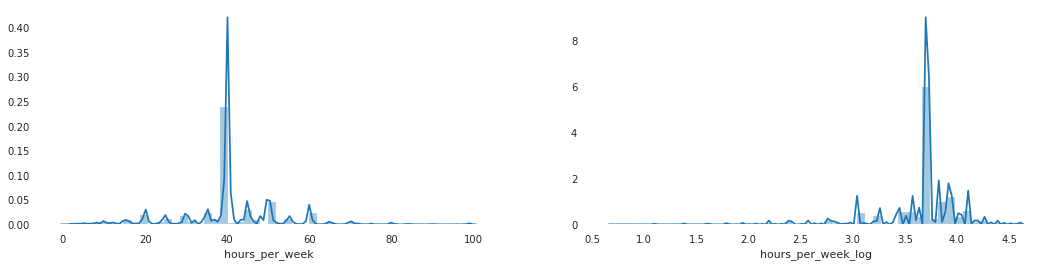

In [27]:
figure, (ax1, ax2) = plt.subplots(nrows=1, ncols=2)
figure.set_size_inches(18, 4)


sns.distplot(df["hours_per_week"], ax=ax1)
sns.distplot(df["hours_per_week_log"], ax=ax2)

In [28]:
from sklearn.ensemble import RandomForestRegressor
from sklearn.preprocessing import LabelEncoder
# one hot 인코딩

dtypes = df.dtypes
encoders = {}
for column in df.columns:
    if str(dtypes[column]) == 'object':
        encoder = LabelEncoder()
        encoder.fit(df[column])
        encoders[column] = encoder
df_num = df.copy()

for column in encoders.keys():
    encoder = encoders[column]
    df_num[column] = encoder.transform(df[column])
    
print(df_num.shape)
df_num.tail(10)

(26049, 20)


,id,age,workclass,fnlwgt,education_num,marital_status,occupation,relationship,race,sex,capital_gain,capital_loss,hours_per_week,native_country,income,is_income_over_50K,capital_gain_bool,capital_loss_bool,age_bin,hours_per_week_log
26039,26039,52,1,129177,9,0,1,1,4,0,0,0,40,38,0,False,False,False,8,3.713572
26040,26040,39,4,30269,11,0,12,4,4,0,0,0,40,38,0,False,False,False,5,3.713572
26041,26041,44,4,103233,13,4,1,4,2,0,0,0,40,38,0,False,False,False,6,3.713572
26042,26042,48,6,191389,10,5,12,4,4,0,0,0,50,38,0,False,False,False,7,3.931826
26043,26043,34,6,234960,13,2,10,0,2,1,0,1887,48,38,1,True,False,True,4,3.891820
26044,26044,57,4,250201,7,2,8,0,4,1,0,0,52,38,0,False,False,False,8,3.970292
26045,26045,23,4,238092,13,4,10,3,4,1,0,0,40,38,0,False,False,False,1,3.713572
26046,26046,78,0,165694,14,6,0,1,4,0,0,0,15,38,0,False,False,False,9,2.772589
26047,26047,26,6,151626,9,4,10,3,2,0,0,0,40,38,0,False,False,False,1,3.713572
26048,26048,20,0,99891,10,4,0,3,4,0,0,0,30,38,0,False,False,False,0,3.433987


In [29]:
# test one hot 인코딩

dtypes = df_t.dtypes
encoders = {}
for column in df_t.columns:
    if str(dtypes[column]) == 'object':
        encoder = LabelEncoder()
        encoder.fit(df_t[column])
        encoders[column] = encoder
df_num_t = df_t.copy()

for column in encoders.keys():
    encoder = encoders[column]
    df_num_t[column] = encoder.transform(df_t[column])
    
print(df_num_t.shape)
df_num_t.tail(10)

(6512, 19)


,id,age,workclass,fnlwgt,education,education_num,marital_status,occupation,relationship,race,sex,capital_gain,capital_loss,hours_per_week,native_country,capital_gain_bool,capital_loss_bool,age_bin,hours_per_week_log
6502,6502,25,4,198587,15,10,4,13,1,2,0,2174,0,50,39,True,False,1,3.931826
6503,6503,70,6,124449,12,14,2,4,0,4,1,0,2246,8,39,False,True,9,2.197225
6504,6504,41,4,163322,1,7,0,4,4,4,0,0,0,36,39,False,False,5,3.610918
6505,6505,55,4,171015,15,10,4,1,3,4,0,0,0,36,39,False,False,8,3.610918
6506,6506,56,4,112840,11,9,2,4,0,4,1,0,0,55,39,False,False,8,4.025352
6507,6507,35,4,61343,9,13,2,12,0,4,1,0,0,40,39,False,False,4,3.713572
6508,6508,41,5,32185,9,13,2,13,0,4,1,0,0,40,39,False,False,5,3.713572
6509,6509,39,4,409189,4,3,2,8,0,4,1,0,0,40,26,False,False,5,3.713572
6510,6510,35,4,180342,11,9,2,3,0,4,1,0,0,40,39,False,False,4,3.713572
6511,6511,28,4,156819,11,9,0,6,4,4,0,0,0,36,39,False,False,2,3.610918


# Feature Engineering (step.05)

In [70]:
# encode
to_encode = ['workclass', 'marital_status',
             'occupation', 'relationship', 'race', 'sex', 'native_country']

encoded = pd.get_dummies(df[to_encode])
encoded_t = pd.get_dummies(df_t[to_encode])
encoded['native_country_Holand-Netherlands'] = 0

In [71]:
df.columns

Index(['id', 'age', 'workclass', 'fnlwgt', 'education_num', 'marital_status',
       'occupation', 'relationship', 'race', 'sex', 'capital_gain',
       'capital_loss', 'hours_per_week', 'native_country', 'income',
       'is_income_over_50K', 'capital_gain_bool', 'capital_loss_bool',
       'age_bin', 'hours_per_week_log', 'Male_married_14y_edu', 'ceo_prof_m'],
      dtype='object')

In [72]:
features = ['education_num','capital_gain_bool', 'age_bin', 'hours_per_week_log', 'Male_married_14y_edu', 'ceo_prof_m']
target = 'is_income_over_50K'

In [73]:
preprocessed = df[features]
preprocessed_t = df_t[features]

In [74]:
print(preprocessed.shape)
print(preprocessed_t.shape)

(26049, 6)
(6512, 6)


In [69]:
X_train

,workclass,education_num,marital_status,occupation,capital_gain_bool,age_bin,hours_per_week_log,Male_married_14y_edu,ceo_prof_m,workclass_?,...,native_country_Puerto-Rico,native_country_Scotland,native_country_South,native_country_Taiwan,native_country_Thailand,native_country_Trinadad&Tobago,native_country_United-States,native_country_Vietnam,native_country_Yugoslavia,native_country_Holand-Netherlands
0,Private,9,Married-civ-spouse,Sales,False,5,4.110874,False,False,0,...,0,0,0,0,0,0,1,0,0,0
1,Private,5,Never-married,Machine-op-inspct,False,0,3.044522,False,False,0,...,0,0,0,0,0,0,1,0,0,0
2,Private,10,Never-married,Other-service,False,0,2.833213,False,False,0,...,0,0,0,0,0,0,1,0,0,0
3,Private,10,Never-married,Prof-specialty,False,0,3.258097,False,False,0,...,0,0,0,0,0,0,1,0,0,0
4,Private,10,Never-married,Adm-clerical,False,1,3.044522,False,False,0,...,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
26044,Private,7,Married-civ-spouse,Other-service,False,8,3.970292,False,False,0,...,0,0,0,0,0,0,1,0,0,0
26045,Private,13,Never-married,Prof-specialty,False,1,3.713572,False,False,0,...,0,0,0,0,0,0,1,0,0,0
26046,?,14,Widowed,?,False,9,2.772589,False,False,1,...,0,0,0,0,0,0,1,0,0,0
26047,Self-emp-not-inc,9,Never-married,Prof-specialty,False,1,3.713572,False,False,0,...,0,0,0,0,0,0,1,0,0,0


In [75]:
X_train = pd.concat([preprocessed, encoded], axis=1)
X_test = pd.concat([preprocessed_t, encoded_t], axis=1)
y_train = df[target]

print(X_train.shape)
print(X_test.shape)
print(y_train.shape)

(26049, 92)
(6512, 92)
(26049,)


# Model Tuning & Evaluation (step.06)

In [76]:
# LOAD LIBRARY
import gc
import os
import random
import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
plt.style.use('fivethirtyeight')
plt.show()

import seaborn as sns
sns.set(style="whitegrid")

import warnings
warnings.filterwarnings('ignore')


import lightgbm as lgb

from time import time
from tqdm import tqdm_notebook
from sklearn import preprocessing
from sklearn.model_selection import GridSearchCV
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import KFold
from sklearn.metrics import f1_score
warnings.simplefilter('ignore')
sns.set()
%matplotlib inline

In [77]:
def lgb_f1_score(y_hat, data):
    y_true = data.get_label()
    y_hat  = np.round(y_hat)
    
    return 'f1', f1_score(y_true, y_hat, average='weighted'), True

In [78]:
params = {
          'objective': 'binary',
          'max_depth': -1,
          'learning_rate': 0.001,
          'num_leaves': 50,
          'min_data_in_leaf': 30,
          "boosting_type": 'gbdt',
          "verbosity": -1,
          'random_state': 15,
          }

In [79]:
%%time
NFOLDS = 5
folds = KFold(n_splits=NFOLDS)

columns = X_train.columns
splits = folds.split(X_train, y_train)
y_preds = np.zeros(X_test.shape[0])
y_oof = np.zeros(X_train.shape[0])
score = 0

feature_importances = pd.DataFrame()
feature_importances['feature'] = columns

CPU times: user 2.01 ms, sys: 763 µs, total: 2.78 ms
Wall time: 2.31 ms


In [ ]:

for fold_n, (trn_idx, val_idx) in enumerate(splits):
    X_trn, X_val = X_train[columns].iloc[trn_idx], X_train[columns].iloc[val_idx]
    y_trn, y_val = y_train.iloc[trn_idx], y_train.iloc[val_idx]
    
    dtrain = lgb.Dataset(X_trn, label=y_trn)
    dvalid = lgb.Dataset(X_val, label=y_val)
    
    clf = lgb.train(
        params,
        dtrain,
        10000,
        valid_sets = [dtrain, dvalid],
        verbose_eval=200,
        early_stopping_rounds=500,
        feval=lgb_f1_score
    )
    
    feature_importances[f'fold_{fold_n+1}'] = clf.feature_importance()
    
    y_pred_val = clf.predict(X_val) 
#     y_pred_val = np.where(y_pred_val >= 0.5, 1, 0)
    y_pred_val = [int(v >= 0.5) for v in y_pred_val]
    
    y_oof[val_idx] = y_pred_val
    print(f"Fold {fold_n + 1} | F1 Score: {f1_score(y_val, y_pred_val, average='weighted')}")
    
    score += f1_score(y_val, y_pred_val, average='weighted') / NFOLDS
    y_preds += clf.predict(X_test) / NFOLDS
    
    del X_trn, X_val, y_trn, y_val
    gc.collect()
    
print(f"\nMean F1 score = {score}")
print(f"OOF F1 score = {f1_score(y, y_oof, average='weighted')}")

Training until validation scores don't improve for 500 rounds
[200]	training's binary_logloss: 0.490304	training's f1: 0.65275	valid_1's binary_logloss: 0.48791	valid_1's f1: 0.656988
[400]	training's binary_logloss: 0.447822	training's f1: 0.65275	valid_1's binary_logloss: 0.446881	valid_1's f1: 0.656988
[600]	training's binary_logloss: 0.417689	training's f1: 0.705752	valid_1's binary_logloss: 0.417881	valid_1's f1: 0.708817
[800]	training's binary_logloss: 0.39527	training's f1: 0.794341	valid_1's binary_logloss: 0.396642	valid_1's f1: 0.798643
[1000]	training's binary_logloss: 0.378142	training's f1: 0.811864	valid_1's binary_logloss: 0.380751	valid_1's f1: 0.80882
[1200]	training's binary_logloss: 0.364886	training's f1: 0.824253	valid_1's binary_logloss: 0.368596	valid_1's f1: 0.820837
[1400]	training's binary_logloss: 0.354398	training's f1: 0.830811	valid_1's binary_logloss: 0.359566	valid_1's f1: 0.824373
[1600]	training's binary_logloss: 0.34604	training's f1: 0.838477	valid_

# Fit (step.07)

In [ ]:
y_preds = np.where(y_preds >= 0.5, 1, 0)

# Submmision (step.08)

In [ ]:
submission = pd.read_csv(path + 'sample_submission.csv')
submission["prediction_bool"] = y_preds
z
submission.loc[submission["prediction_bool"] == True, 'prediction'] = 1
submission.loc[submission["prediction_bool"] == False, 'prediction'] = 0

submission = submission.drop("prediction_bool", axis = 1)

print(submission.shape)
submission.head()

In [ ]:
submission.to_csv('submission_T-AcademyXKaKr-201024_2.csv'', index = False)